# Project 3

In this project, we apply machine learning methods to predict Consumer Price Index. 

After obtaining the predicted CPI, we would then calculate monthly and yearly inflation.

After carefully considering the underlying structure of the data, we decided to build models using the period 2010-2020

- 2010 - 2017 as training data

- 2017 - 2019 as validation data

- 2019 - 2020 as test data


# I. Preprocessing 

## 1. Label Decomposition

Import necessary library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss


In [2]:
# Read in the data

df = pd.read_csv('cpi.csv', parse_dates= [['Year', 'Month']], index_col= 'Year_Month')

# get data from 2010 to 2020
df = df.loc['2010-01-01':'2020-01-01']

# Set the monthly frequency for the data

df.index.freq = 'MS'

# Change the index name to 'Date'
df.index.name = 'Date'

/var/folders/4t/srsszr7n11d5dyln69f_59t00000gn/T/ipykernel_13446/778798877.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('cpi.csv', parse_dates= [['Year', 'Month']], index_col= 'Year_Month')


Visualize monthly and yearly inflation

Text(0.5, 1.0, '1-month inflation rate')

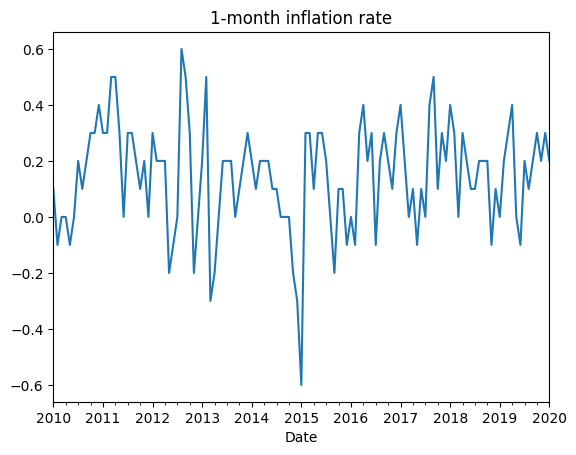

In [3]:
df['1-Month % Change'].plot()
plt.title('1-month inflation rate')

Text(0.5, 1.0, '12-month inflation rate')

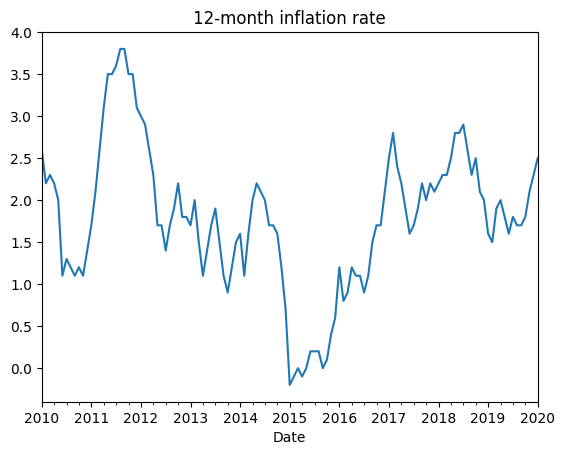

In [4]:
df['12-Month % Change'].plot()
plt.title('12-month inflation rate')

Our current main focus is the CPI index, so let's decompose this feature first.
- First, decompose the CPI column into trend, seasonal, and residual components using additive method. 
- Second, apply multiplicative method
- Since we may apply detrending method as a way to make the data stationary, we will be using backward looking moving average in order to smooth out the noise (instead of the center moving average) and reduce the number of future observation lost. 


In [5]:
df['CPI'].describe()

count    121.000000
mean     237.294322
std       11.203110
min      217.199000
25%      229.187000
50%      237.231000
75%      244.243000
max      259.037000
Name: CPI, dtype: float64

### 1.1 Additive decomposition

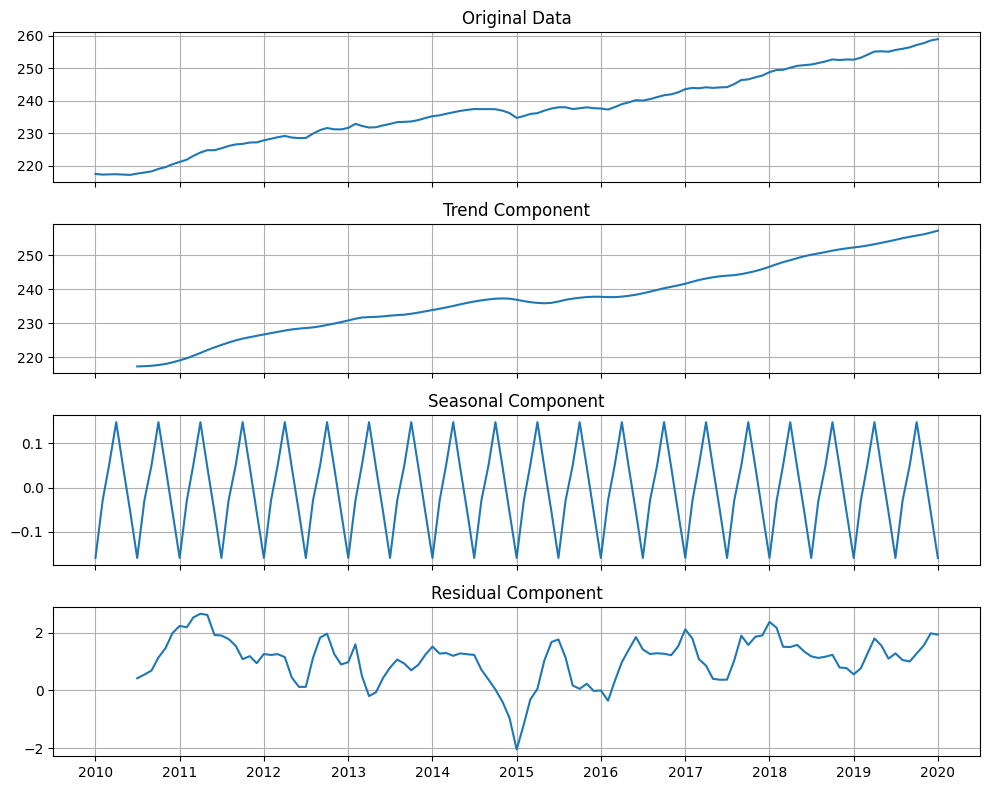

In [6]:
additive_decomposed = seasonal_decompose(df['CPI'], model='additive',two_sided= False, period= 6)

# Plot the original data, trend, seasonal, and residual components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original data
ax1.plot(df['CPI'])
ax1.set_title('Original Data')
ax1.grid()

# Trend component
ax2.plot(additive_decomposed.trend)
ax2.set_title('Trend Component')
ax2.grid()

# Seasonal component
ax3.plot(additive_decomposed.seasonal)
ax3.set_title('Seasonal Component')
ax3.grid()

# Residual component
ax4.plot(additive_decomposed.resid)
ax4.set_title('Residual Component')
ax4.grid()

plt.tight_layout()
plt.show()


A statistical look into the seasonal component

In [7]:
additive_decomposed.seasonal.describe()

count    121.000000
mean      -0.001312
std        0.097234
min       -0.158736
25%       -0.055376
50%       -0.029292
75%        0.050357
max        0.147449
Name: seasonal, dtype: float64

### 1.2 Multiplicative Decomposition

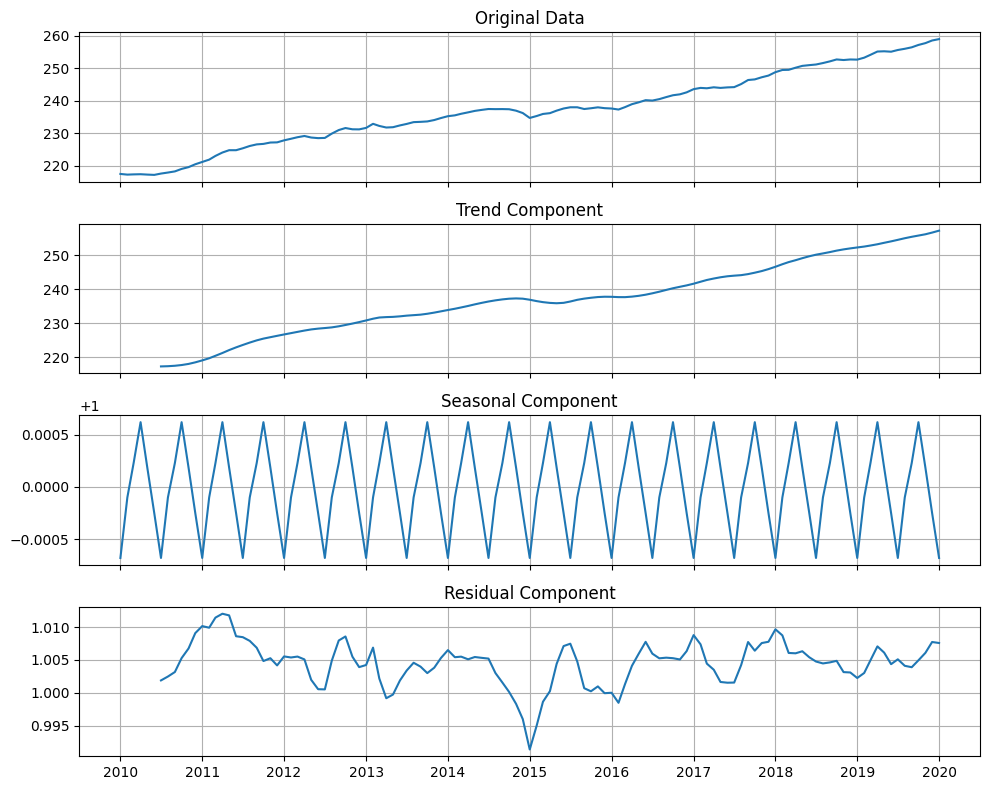

In [8]:
multiplicative_decomposed = seasonal_decompose(df['CPI'], model='multiplicative',two_sided= False, period= 6)

# Plot the original data, trend, seasonal, and residual components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original data
ax1.plot(df['CPI'])
ax1.set_title('Original Data')
ax1.grid()

# Trend component
ax2.plot(multiplicative_decomposed.trend)
ax2.set_title('Trend Component')
ax2.grid()

# Seasonal component
ax3.plot(multiplicative_decomposed.seasonal)
ax3.set_title('Seasonal Component')
ax3.grid()

# Residual component
ax4.plot(multiplicative_decomposed.resid)
ax4.set_title('Residual Component')
ax4.grid()

plt.tight_layout()
plt.show()


### 1.3 Decomposition Conclusion

- After trying multiple periods/frequencies, we decided to use a period of 6 to decompose the CPI index as it results the perfect seasonal component. 

Both multiplicative and additive decomposition show that the trend component is the most important component in the CPI index. 

However, residuals in the multiplicative decomposition is more stable than in additive approach, so we should move forward with mulitplicative approach. 

## 2. Trend Analysis

In [9]:
# Obtain statistical attributes of the trend component
additive_decomposed.trend.describe()

count    115.000000
mean     237.269942
std       10.465135
min      217.345417
25%      230.162375
50%      236.954083
75%      244.336583
max      257.265667
Name: trend, dtype: float64

Since the series has a linear trend, it is definitely not stationary. Thus, we should attempt to make it stationary.

In addition, we can address how statistical properties of a series change over time by visualizing. This would help us check the structural break and heteroscedasticity issue. 
- The rolling window size is 12 months

In [10]:
# Create a fucntion to plot rolling variance and rolling mean
def rolling_statistics(timeseries, custom_name, window_size=12):
    # Determine rolling statistics
    rolling_mean = timeseries.rolling(window=window_size).mean()
    rolling_std = timeseries.rolling(window=window_size).std()

    # Plot rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_mean, color='black', label='Rolling Mean')
    plt.plot(rolling_std, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation of ' + custom_name)
    plt.grid()
    plt.show()

### 2.1 Label Diffencing

First, let's work on differncing the data to see if the process can make the data more stationay. 

#### 2.1.1 First Order Differencing

In the first order differencing, we would subtract the immediate previous value from the current value to obtain the difference between two consecutive periods. 

First-Order Differencing = Value at time t - Value at time t-1

In [11]:
diff_data = df['CPI'].diff().dropna()


Text(0.5, 1.0, 'First - Order Differenced Data')

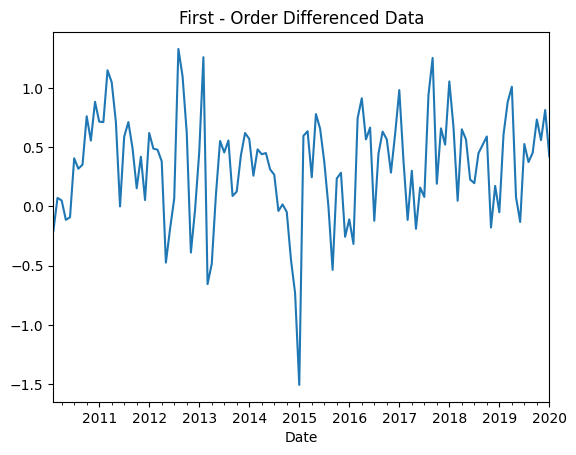

In [12]:
diff_data.plot()
plt.title('First - Order Differenced Data')

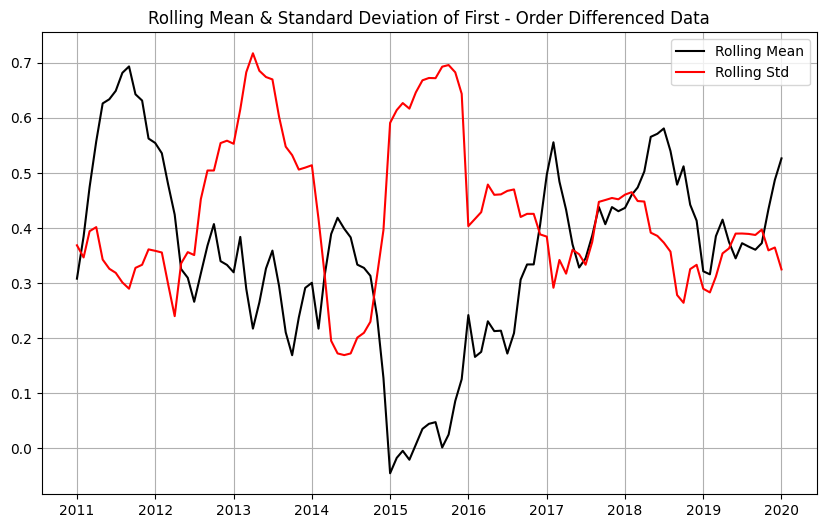

In [13]:
rolling_statistics(diff_data, 'First - Order Differenced Data')

#### 2.1.2 Second Order Differencing

In [14]:
second_order_diff = diff_data.diff().dropna()

Text(0.5, 1.0, 'Second - Order Differenced Data')

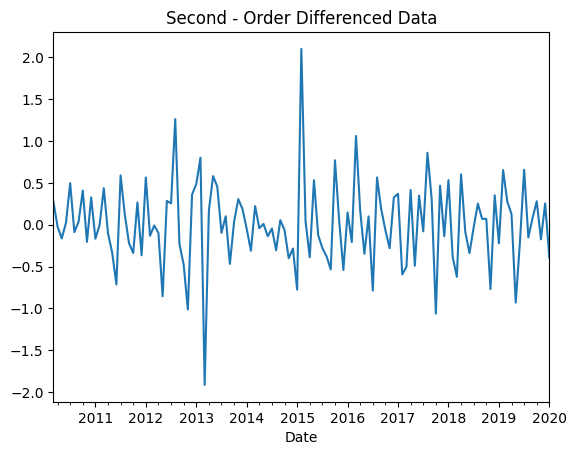

In [15]:
second_order_diff.plot()
plt.title('Second - Order Differenced Data')


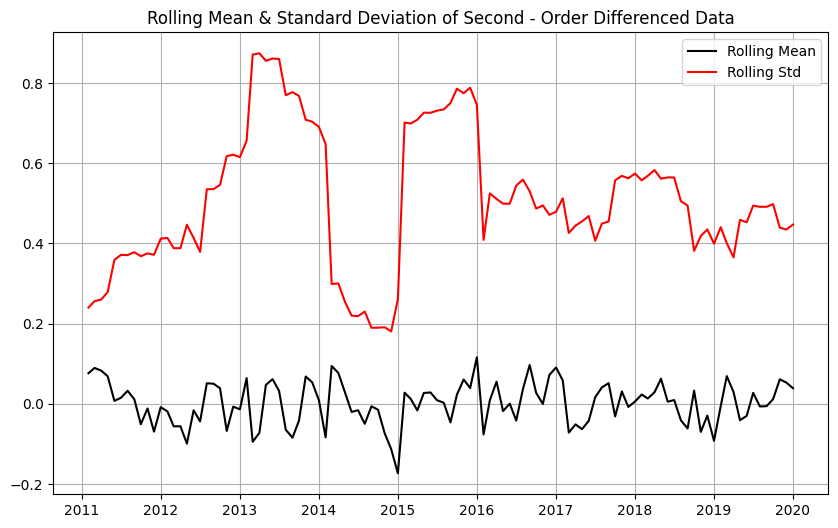

In [16]:
rolling_statistics(second_order_diff, 'Second - Order Differenced Data')

### 2.2 Label Detrending

- The method for smoothing data used in this project is backward moving average.

- Detrended data is computed by subtracting the trend values from the actual values. 

- Since we use a period of 6 to smooth out the data, the function will use a centered moving average witha window size of 6 to smooth the trend component (6 periods prior to the current value).

- As a result, we would lose 6 observations in using label detrending, compared to only 1 in first-order differencing, and 2 in second-order differencing.

In [17]:
# Here, I extract the trend component from the multiplicative decomposition. Trend values from either multiplicative or additive decompositions are identical.
trend = multiplicative_decomposed.trend

In [18]:
detrend = df['CPI']- trend

detrend.dropna(inplace=True)

Text(0.5, 1.0, 'Detrended Data')

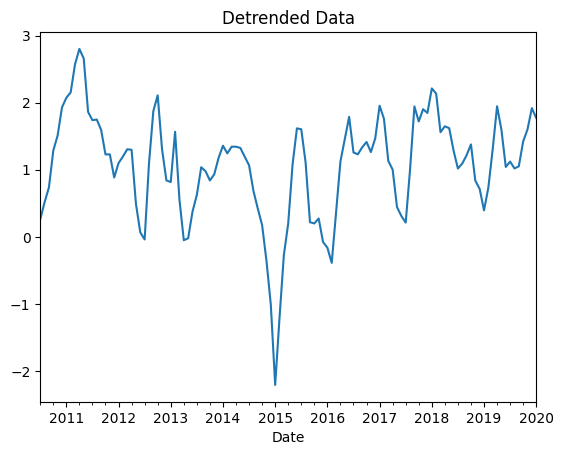

In [19]:
detrend.plot()
plt.title('Detrended Data')

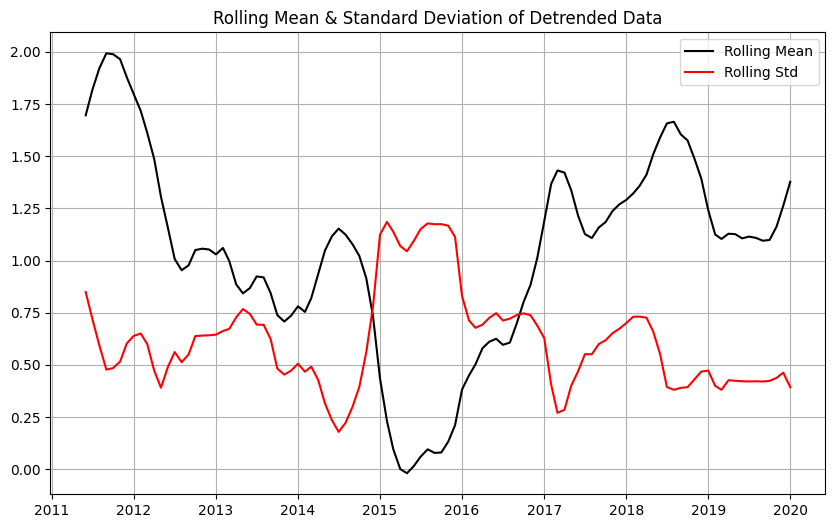

In [20]:
rolling_statistics(detrend, 'Detrended Data')

### 2.3 Differencing and Detrending Conclusion

- Mean and variance of these transformed data are not constant over time. Between the 3 transformation method, the second order differencing appear to be the most stationary. Therefore, we would move forward with second order differencing.

## 3. Label Transformation (Make it stationary)

Create a function to calculate the ADF test and print out the result. 

In [21]:
def stationary_test(input):

    result = adfuller(input)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Reject the null hypothesis if the p-value is below the chosen significance level
    if result[1] < 0.05:
        print("The data is STATIONARY.")
    else:
        print("The data is NOT STATIONARY.")
        

In addition to the ADF test, let's use the non parametric KPSS test to confirm the stationarity of the data. If KPSS's result contradict conclusion from ADF, we need to investigate further. 

### 3.1 Augemnted Dickey-Fuller Test

To statistically verify if the data is stationary or not, we would deploy ADF test. 

- Null hypothesis: The time series contains a unit root and is non-stationary

- Alternative hypothesis is that the time series is stationary. 

To confirm that the data is stationary, we need a p-value that is lower than the significance level in order to reject the null hypothesis, and the critical values should be greater greater than the ADF statistics.

- The significance level chosen is 0.05. 

1. ADF on the orignal dataset

In [22]:
stationary_test(df['CPI'])

ADF Statistic: 0.040689036700748346
p-value: 0.9617704479917902
Critical Values: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
The data is NOT STATIONARY.


2. ADF on the second order differenced dataset

In [23]:
stationary_test(second_order_diff)

ADF Statistic: -5.80618997008413
p-value: 4.510765451741595e-07
Critical Values: {'1%': -3.49181775886872, '5%': -2.8884437992971588, '10%': -2.5811201893779985}
The data is STATIONARY.


### 3.2 Non-parametric KPSS test

- Null hypothesis: The time series is stationary (no unit root)

- Alternative hypothesis: The time series is stastionary (it has a unit root)

KPSS' test statistic is compared to the relevant critical values. If the test statistic is greater than the cirtical value at a chosen level of significance, we reject the null hypothesis  and conclude that the series is non-stationary with a unit root. 


In [24]:
# Create a function to perform the kpss test.
def kpss_test(input):
        result = kpss(input)
        print('KPSS Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:', result[3])
    
        # Reject the null hypothesis if the p-value is below the chosen significance level
        if result[1] < 0.05:
            print("The data is NOT STATIONARY.")
        else:
            print("The data is STATIONARY.")


1. KPSS test on the orignal data

In [25]:
kpss_test(df['CPI'])

KPSS Statistic: 1.7595184554889154
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The data is NOT STATIONARY.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


2. KPSS test on the second-order differenced data

In [26]:
kpss_test(second_order_diff)

KPSS Statistic: 0.11529710834087968
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The data is STATIONARY.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Most critical values across level of significance are well beyond the test statistic. This supports the Null hypothesis that the series is stationary

### 3.3 ADF and KPSS test conclusion 

The second-order differencing data is found to be stationary by using ADF and KPSS test, while the original data is not stationary (as expected). Results from both test are consistent.

In [27]:
# Create a box plot to compare the distribution of the detrended data and the first-order differenced data
def cus_boxplot(data1, title1):
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    sns.boxplot(data1, ax=ax1)
    ax1.set_title(title1)
    plt.show()

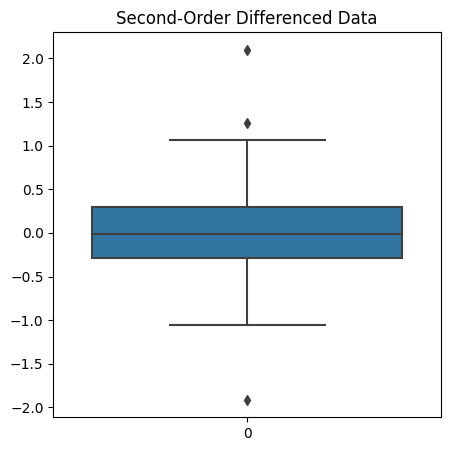

In [28]:
cus_boxplot(second_order_diff, 'Second-Order Differenced Data')

In [29]:
# Get the data statisitcal summary

print('Second order difference data statistical summary:')
second_order_diff.describe()

Second order difference data statistical summary:


count    119.000000
mean       0.005277
std        0.501570
min       -1.913000
25%       -0.282000
50%       -0.009000
75%        0.295500
max        2.100000
Name: CPI, dtype: float64

## 4. Lag Analysis

To identify the useful lag variables, we can use the autocorrelation function (ACF) and Partial Autocorrelation Function (PACF) plots.

The main difference between ACF and PACF is that ACF measures the total correlation between a time series and its lagged values, while PACF measures the direct correlation between a time series and its lagged values after removing the effect of the correlations with the intervening observations. 

ACF is primarily used to determine the MA component, while the PACF plot is used to determine the AR component.

The shaded area is the signifiance level in the ACF and PACF plots. If a lag is above the shaded area, it is significantly correlated with the label. 

### 4.1 Label's ACF and PACF

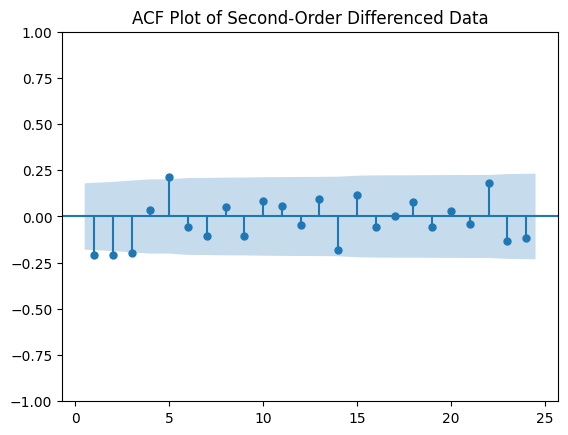

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


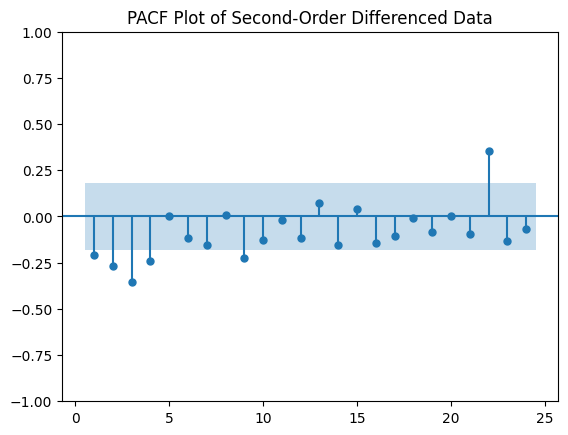

In [30]:
# ACF plot
plot_acf(second_order_diff, lags= 24, zero=False)
plt.title('ACF Plot of Second-Order Differenced Data')
plt.show()

# PACF plot
plot_pacf(second_order_diff, lags = 24, zero=False)
plt.title('PACF Plot of Second-Order Differenced Data')
plt.show()

### 4.2 Lag Analysis Conclusion 

- The ACF plot shows that the label is correlated with its lagged values up to 3 periods.

- Meanwhile, the PACF shows that the label is directly correlated with the first 4 lag values and lags of 9 and 22. We can't really be sure that lag 22 are really substantially significnnt as it shows on the graph due to the small size of the data.

## 5. Splitting the data

In [64]:
# Training, validation, and test sets

train = second_order_diff.loc['2010-01-01':'2016-12-31']

val = second_order_diff.loc['2017-01-01':'2018-12-31']

test = second_order_diff.loc['2019-01-01':'2019-12-31']


## 1. Base model: ARIMA(1,2,1)

- The ARIMA model contains 3 main components: AR, I (differencing), and MA.

- After carefully taking into consideration, second-order differencing seems to be the best way to make the data stationary so decided to use it as the base model for comparision purpose.

- The model takes into account 1 lagged values, 1 lagged errors, and 2 order differencing. 

### 1.1 Model Executing

In [67]:
from statsmodels.tsa.arima.model import ARIMA

# Create and fit an ARIMA(1,2,1) model to the training set

#! Here we set I = 0 since we have manually differenced the data
base_model = ARIMA(train, order=(1,0,1)).fit()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### 1.2 Model Summary

In [68]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CPI   No. Observations:                   82
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -49.853
Date:                Sat, 29 Apr 2023   AIC                            107.706
Time:                        10:43:34   BIC                            117.333
Sample:                    03-01-2010   HQIC                           111.571
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.006     -0.283      0.777      -0.013       0.010
ar.L1          0.4187      0.124      3.378      0.001       0.176       0.662
ma.L1         -0.9999     16.385     -0.061      0.951     -33.114      31.114
sigma2         0.1892      3.092      0.061      0.951      -5.870       6.248
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                13.99
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                            -0.59
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
# Forecast values for the validation set
validation_forecast = base_model.forecast(steps=len(val))

# Calculate evaluation metrics
mae = np.mean(np.abs(validation_forecast - val))
mse = np.mean((validation_forecast - val)**2)
rmse = np.sqrt(mse)

# Print evaluation metrics
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")


MAE: 0.41, MSE: 0.24, RMSE: 0.49


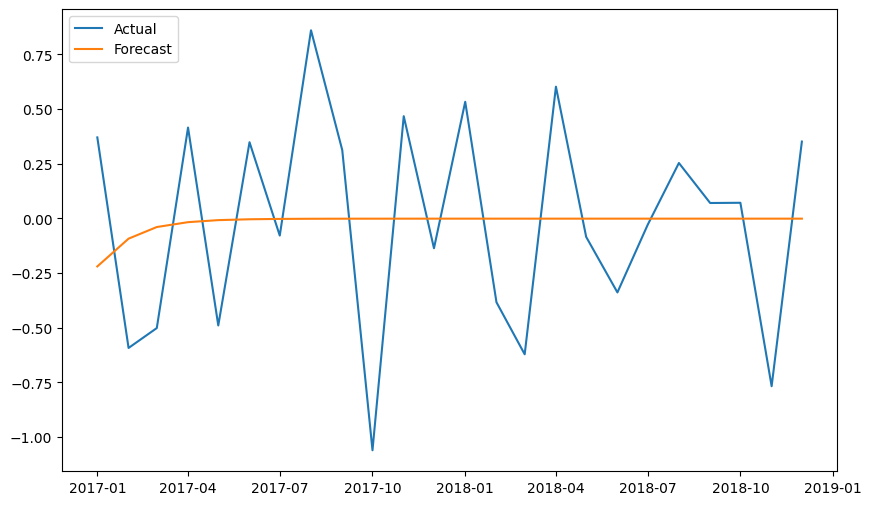

In [74]:
# Plot the forecasted values and the actual values
plt.figure(figsize=(10, 6))
plt.plot(val, label='Actual')
plt.plot(validation_forecast, label='Forecast')
plt.legend(loc='upper left')


In [77]:
validation_forecast.describe()

count    24.000000
mean     -0.017272
std       0.047543
min      -0.220077
25%      -0.003199
50%      -0.001623
75%      -0.001613
max      -0.001613
Name: predicted_mean, dtype: float64